In [575]:
import pandas as pd

# import modules automatically after changes
%load_ext autoreload
%autoreload 2
# Show plots in the notebook
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports

In [576]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import argrelextrema
import seaborn as sns

from src.utils import load_config

In [577]:
# Set plot style
plt.rcParams["mathtext.fontset"] = "stix"
# plt.rcParams["font.family"] = "STIXGeneral"
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.titlesize"] = 14
%config InlineBackend.figure_format = 'retina'
# Set color palette
# sns.set_style("whitegrid")

# Load data

In [578]:
# # set working directory to project root - EXECUTE ONLY ONCE or RESTART KERNEL
# os.chdir('..')
os.getcwd()

'C:\\Users\\merti\\PycharmProjects\\sem-outbreak-detection'

In [579]:
# Load configs
config = load_config("config.yaml")

In [580]:
data = pd.read_pickle(
    config["data"]["processed_data_dir"] + "cleaned_noro_rotavirus_reports_GER.pkl"
)

In [581]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1196 entries, 0 to 1195
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   seasonYear       1196 non-null   object        
 1   seasonWeek       1196 non-null   int64         
 2   reports          1196 non-null   int64         
 3   calendarYear     1196 non-null   int64         
 4   calendarWeek     1196 non-null   int64         
 5   week_start_date  1196 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 56.2+ KB


In [582]:
seasonal_decomposition = pd.read_pickle(
    config["data"]["processed_data_dir"] + "seasonal_decomposition.pkl"
)

In [583]:
seasonal_decomposition.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1196 entries, 0 to 1195
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   seasonYear       1196 non-null   object        
 1   seasonWeek       1196 non-null   int64         
 2   calendarYear     1196 non-null   int64         
 3   calendarWeek     1196 non-null   int64         
 4   week_start_date  1196 non-null   datetime64[ns]
 5   observed         1196 non-null   float64       
 6   trend            1196 non-null   float64       
 7   seasonal         1196 non-null   float64       
 8   resid            1196 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(3), object(1)
memory usage: 84.2+ KB


In [584]:
seasonal_decomposition[100:200]

,seasonYear,seasonWeek,calendarYear,calendarWeek,week_start_date,observed,trend,seasonal,resid
100,2002/03,49,2003,23,2003-06-02,784.0,1244.509615,-678.830246,218.320631
101,2002/03,50,2003,24,2003-06-09,515.0,1232.932692,-877.452911,159.520219
102,2002/03,51,2003,25,2003-06-16,490.0,1218.730769,-1029.484857,300.754088
103,2002/03,52,2003,26,2003-06-23,469.0,1206.788462,-1160.880515,423.092054
104,2003/04,1,2003,27,2003-06-30,437.0,1197.134615,-1275.395469,515.260853
...,...,...,...,...,...,...,...,...,...
195,2004/05,40,2005,13,2005-03-28,3146.0,1920.269231,1342.963536,-117.232767
196,2004/05,41,2005,14,2005-04-04,3299.0,1910.884615,1178.344216,209.771169
197,2004/05,42,2005,15,2005-04-11,3471.0,1901.653846,1031.495799,537.850355
198,2004/05,43,2005,16,2005-04-18,3570.0,1890.673077,960.333000,718.993923


# Simulate outbreaks
The aim is to simulate outbreaks (with exponential increase) in a time series of reported cases. The outbreaks are simulated by adding a random number of cases at a random time point in the time series. The outbreaks are tested in different time points (peak, middle or low seasonal activity) to assess the performance of the algorithm in detecting outbreaks at different stages of the epidemic curve.

**Bullet points**:
    * Randomly placed in a week in the time series
    * With added excess cases (e.g., 10x the baseline incidence)
    * Test outbreaks in different time points (peak, middle or low seasonal activity)


## Find peaks, mids and lows
Identify seasonal peaks, mids and lows intervals (weekly interval) using the seasonal decomposition of the time series as potential outbreak locations. They then can be used as centers for the simulated outbreaks an ensures that outbreaks are simulated at different stages of the epidemic curve.

In [585]:
order = config["simulation"]["spread_weeks"] * 2 + 1
print("Order for argrelextrema:", order)
peaks = argrelextrema(
    seasonal_decomposition["seasonal"].values, np.greater, order=order
)[0]
lows = argrelextrema(seasonal_decomposition["seasonal"].values, np.less, order=order)[0]
mids = np.sort(np.concatenate((peaks, lows)))
mids = np.diff(mids) // 2 + mids[:-1]

Order for argrelextrema: 7


In [586]:
# Add to DataFrame
df_temp = seasonal_decomposition.copy()
df_temp["peak"] = df_temp.index.isin(peaks)
df_temp["low"] = df_temp.index.isin(lows)
df_temp["mid"] = df_temp.index.isin(mids)
df_temp.head(10)

,seasonYear,seasonWeek,calendarYear,calendarWeek,week_start_date,observed,trend,seasonal,resid,peak,low,mid
0,2001/02,1,2001,27,2001-07-02,430.0,921.160292,-1275.395469,784.235177,False,False,False
1,2001/02,2,2001,28,2001-07-09,362.0,926.577825,-1297.571649,732.993824,False,False,False
2,2001/02,3,2001,29,2001-07-16,280.0,931.995359,-1378.805104,726.809745,False,False,False
3,2001/02,4,2001,30,2001-07-23,268.0,937.412893,-1424.090816,754.677923,False,False,False
4,2001/02,5,2001,31,2001-07-30,232.0,942.830426,-1461.219756,750.389329,False,False,False
5,2001/02,6,2001,32,2001-08-06,236.0,948.247960,-1495.635902,783.387942,False,True,False
6,2001/02,7,2001,33,2001-08-13,237.0,953.665494,-1478.130645,761.465151,False,False,False
7,2001/02,8,2001,34,2001-08-20,213.0,959.083027,-1448.501641,702.418614,False,False,False
8,2001/02,9,2001,35,2001-08-27,202.0,964.500561,-1408.051149,645.550588,False,False,False
9,2001/02,10,2001,36,2001-09-03,239.0,969.918095,-1387.140373,656.222278,False,False,False


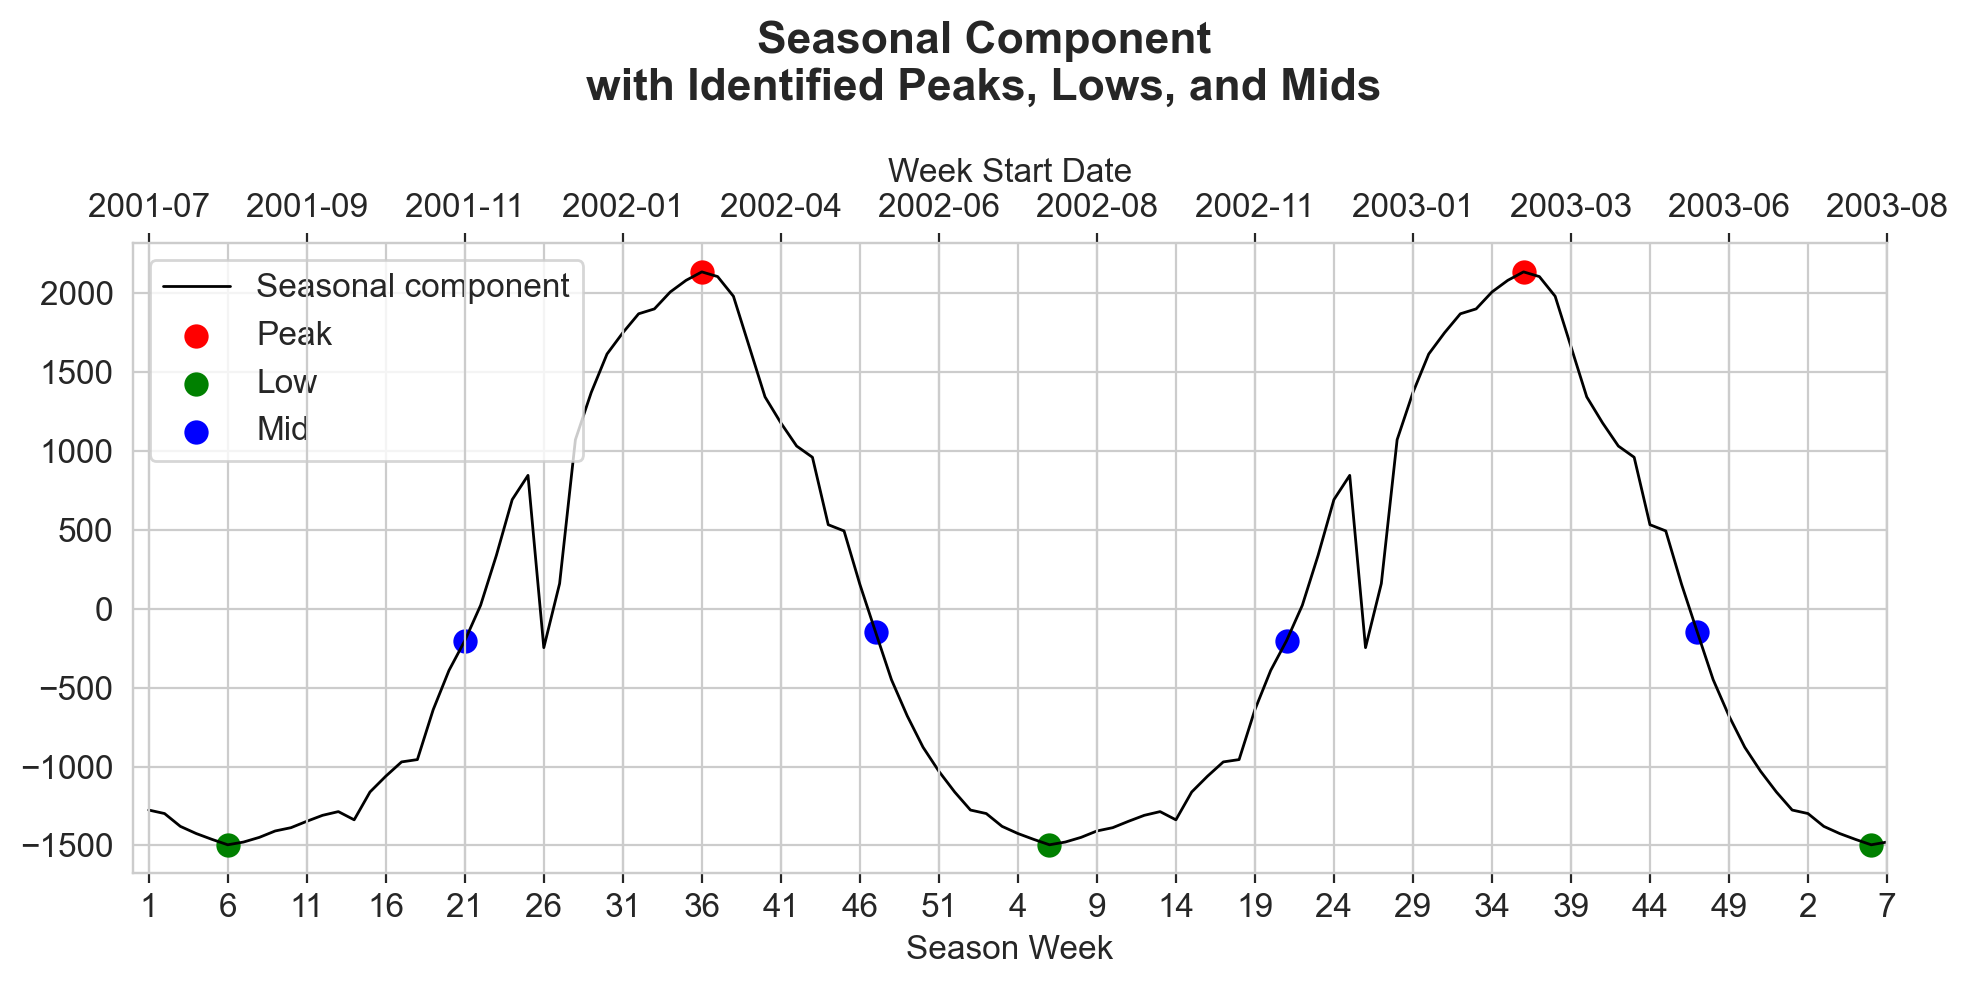

In [587]:
# Check if peaks, lows and mids are correctly identified
fig, ax = plt.subplots(figsize=(10, 5))

# Plot seasonal component
plt.plot(df_temp["seasonal"], label="Seasonal component", color="black", linewidth=1)

# Plot peak, low, and mid points with enhanced labels and markers
peak_indices = df_temp.index[df_temp["peak"]]
low_indices = df_temp.index[df_temp["low"]]
mid_indices = df_temp.index[df_temp["mid"]]

ax.scatter(
    peak_indices, df_temp["seasonal"][df_temp["peak"]], color="red", label="Peak", s=60
)
ax.scatter(
    low_indices, df_temp["seasonal"][df_temp["low"]], color="green", label="Low", s=60
)
ax.scatter(
    mid_indices, df_temp["seasonal"][df_temp["mid"]], color="blue", label="Mid", s=60
)

# Set x-axis: Periodic ticks and custom labels
ax.set_xlabel("Season Week")
period = 5
ax.set_xticks(df_temp.index[::period])
ax.set_xticklabels(df_temp["seasonWeek"][::period])
ax.xaxis.set_ticks_position("bottom")
ax.set_xlim(-1, 110)

# Set secondary x-axis with week start date
secondary_axis = ax.twiny()
secondary_axis.set_xlabel("Week Start Date")
secondary_axis.set_xticks(df_temp.index[:: period * 2])
secondary_axis.set_xticklabels(
    df_temp["week_start_date"].dt.strftime("%Y-%m")[:: period * 2]
)
secondary_axis.set_xlim(-1, 110)

# Add a title and grid for better visibility
plt.suptitle(
    "Seasonal Component\nwith Identified Peaks, Lows, and Mids",
    fontweight="bold",
    fontsize=16,
)

ax.legend(loc="upper left")

plt.tight_layout()
plt.show()

## Simulate single outbreak

### Parameters:
* center_idx (int): The index that marks the center of the outbreak. This is the point in time (in weeks) around which the outbreak is centered.
* baseline (array): The baseline incidence, which represents the normal or expected number of cases for each week. For this simulation, the baseline is the combination of the seasonal and trend components of the time series.
* multiplier (int): The outbreak's intensity multiplier, which scales the baseline values to generate higher incidences during the outbreak period.
* spread_weeks (int): The number of weeks over which the outbreak will spread. The outbreak will impact weeks before and after the center week (as determined by center_idx).
* time_idx (array): A time-like index (e.g., week numbers or actual dates) that corresponds to the time series. It allows mapping the simulation's results to specific dates or weeks.
* method (str): The method to model the outbreak's spread. Two options are available:
    * "poisson": A Poisson distribution is used to simulate random variations in case numbers.
    * "exponential": An exponential decay function is used to model the spread of the outbreak, with cases peaking at the center and declining over time.
* noise (float): Whether to add Poisson noise to the simulated outbreak. This introduces random fluctuations in the case counts, making the data more realistic.

### Statistical Methodology:
### Formula Update
* $t_{\text{outbreak}}$ be the index of the center of the outbreak (parameter `center_idx` in the code)
* $B(t)$ be the baseline incidence at week $t$ (represented by the `baseline` array in the code)
* $M$ be the outbreak intensity multiplier (parameter `multiplier` in the code), which scales the baseline value at the center of the outbreak
* $S$ be the spread of the outbreak in weeks (parameter `spread_weeks` in the code)
* $t_{\text{offset}} \in [t_{\text{outbreak}} - S, t_{\text{outbreak}} + S]$ be the week offset from the center of the outbreak
* $R_{\text{simulated}}$ be the simulated time series with the outbreak
* $\sigma$ be the variance multiplier for the Poisson noise (parameter `noise` in the code), controlling how much random fluctuation is added

**Poisson Distribution**: A discrete probability distribution that expresses the probability of a given number of events occurring in a fixed interval of time or space.
* The Poisson distribution is commonly used in epidemiology to model rare events like disease outbreaks. It describes the probability of a given number of cases occurring in a fixed period, given a known average rate of occurrence.
* --> The number of cases at each affected week is drawn from a Poisson distribution with mean equal to the baseline incidence multiplied by the outbreak intensity multiplier and the relative weights parameter. The result is that the outbreak intensity fluctuates in a random manner, with some weeks experiencing significantly more cases than others. The total number of simulated cases for a week $t \in T$ is:
* $O(t) \sim \text{Poisson}(M \cdot B(t_{\text{outbreak}}) \cdot w(t))$
* Where $w(t)$ represents the relative weights normalized by the exponential decay function in the code, calculated as: $w(t) = \exp\left(-0.5 \cdot \left(\frac{t_{\text{offset}}}{S}\right)^2\right)$
* --> Given a $t_{\text{outbreak}}$ as the week being the center of the outbreak, the simulated time series is:
* $R_{\text{simulated}}(t) =
\begin{cases}
B(t) + O(t) & \text{if } t \in [t_{\text{outbreak}} - S, t_{\text{outbreak}} + S] \\
B(t) & \text{otherwise}
\end{cases}$

**Exponential Decay**: A mathematical function that describes the decay of a quantity over time.
* The exponential decay method is more deterministic, representing an outbreak that starts at a peak and decreases symmetrically over time. The cases near the center of the outbreak are much more frequent, and the number of cases diminishes as time progresses, following a Gaussian-like distribution.
* --> The number of cases at each affected week is modeled with an exponential decay function, where the intensity is highest at the center and decays symmetrically around it. The total number of simulated cases for a week $t \in T$ and $t_{\text{offset}} \in \left\{-S, -(S-1), ..., 0, ..., S-1, S\right\}$ is:
* $O(t) = M \cdot \exp\left(-0.5 \cdot \left(\frac{t_{\text{offset}}}{S}\right)^2\right)$
* --> Given a $t_{\text{outbreak}}$ as the week being the center of the outbreak, the simulated time series is:
* $R_{\text{simulated}}(t) =
\begin{cases}
B(t) + O(t) & \text{if } t \in [t_{\text{outbreak}} - S, t_{\text{outbreak}} + S] \text{ with } t_{\text{offset}} = t - t_{\text{outbreak}} \\
B(t) & \text{otherwise}
\end{cases}$

Optional **Poisson Noise**: Random fluctuations in the case counts that are added to the simulated outbreak data.
* The Poisson noise is added to the simulated outbreak data for the affected weeks only. It introduces variability and randomness, making the simulated data more realistic but ensuring the baseline weeks remain unchanged since it is real data. The noise is drawn from a Poisson distribution with the baseline incidence as the mean. A new parameter **$\sigma$** (variance multiplier) is introduced to scale the Poisson noise intensity:
* $O_{\text{noise}}(t) \sim \text{Poisson}(\sigma \cdot B(t))$
* --> Given a $t_{\text{outbreak}}$ as the week being the center of the outbreak, the simulated time series with Poisson noise is:
* $R_{\text{simulated}}(t) = R_{\text{simulated}}(t) + O_{\text{noise}}(t)$ if $t \in [t_{\text{outbreak}} - S, t_{\text{outbreak}} + S]$ and $O(t) > 0$


In [588]:
def simulate_outbreak(
    center_idx,
    baseline,
    multiplier,
    spread_weeks,
    time_idx,
    method="exponential",
    noise=0.9,
):
    """
    Simulate an outbreak at a given time point.

    :param center_idx: int
        Index of the center of the outbreak.
    :param baseline: array
        Baseline incidence, which represents the normal or expected number of cases for each week.
    :param multiplier: int
        Intensity of the outbreak.
    :param spread_weeks: int
        Spread of the outbreak in weeks, affecting weeks before and after the center.
    :param time_idx: array
        Datetime-like index for the time series that corresponds to the time series.
    :param method: str
        Method to model the outbreak's spread. Either "poisson" or "exponential".
    :param noise: float
        Add Poisson noise to the simulated outbreak. If None, no noise is added.
    :return: array
        Simulated time series with outbreak and outbreak indicator.
    """
    # Define outbreaks time range
    start_idx = max(0, center_idx - spread_weeks)
    end_idx = min(len(baseline), center_idx + spread_weeks)
    outbreak_weeks = np.arange(start_idx, end_idx + 1)
    print("Outbreak Weeks:", outbreak_weeks)
    # Get weeks relative to the center
    t = np.arange(-spread_weeks, spread_weeks + 1)

    # Simulate outbreak
    outbreak = np.zeros(len(baseline), dtype=int)

    relative_weights = np.exp(-0.5 * (t / spread_weeks) ** 2)
    relative_weights /= relative_weights.sum()  # Normalize weights

    if method == "poisson":
        poisson_rates = multiplier * baseline[center_idx] * relative_weights
        outbreak[outbreak_weeks] = np.random.poisson(poisson_rates)
    if method == "exponential":
        # multiplicative: multiplier * baseline[center_idx] * np.exp(-0.5 * (t / spread_weeks) ** 2)
        # additive to avoid outbreak magnitude depending on baseline:
        outbreak[outbreak_weeks] = np.round(
            multiplier * np.exp(-0.5 * (t / spread_weeks) ** 2)
        ).astype(int)

    # Add Poisson noise (discrete random fluctuations) to the outbreak week(s)
    if noise > 0.0:
        noise_component = np.random.poisson(noise * baseline[outbreak_weeks])
        outbreak[outbreak_weeks] += noise_component

    # Ensure non-negative values
    outbreak = np.clip(outbreak, 0, None)
    combined = baseline + outbreak

    # Set outbreak indicator
    outbreak_indicator = np.array([False] * len(baseline))
    outbreak_indicator[outbreak_weeks] = True

    return combined, outbreak_indicator

In [589]:
# load config
config = load_config("config.yaml")

In [590]:
# Test functionality
baseline = seasonal_decomposition["observed"]
center_idx = 20
baseline_with_outbreak_ex, outbreak_indicator_ex = simulate_outbreak(
    center_idx,
    baseline[:60],
    multiplier=config["simulation"]["multiplier"],
    spread_weeks=config["simulation"]["spread_weeks"],
    time_idx=np.arange(60),
    method="exponential",
    noise=True,
)
baseline_with_outbreak_po, outbreak_indicator_po = simulate_outbreak(
    center_idx,
    baseline[:60],
    multiplier=config["simulation"]["multiplier"],
    spread_weeks=config["simulation"]["spread_weeks"],
    time_idx=np.arange(60),
    method="poisson",
    noise=False,
)

Outbreak Weeks: [17 18 19 20 21 22 23]
Outbreak Weeks: [17 18 19 20 21 22 23]


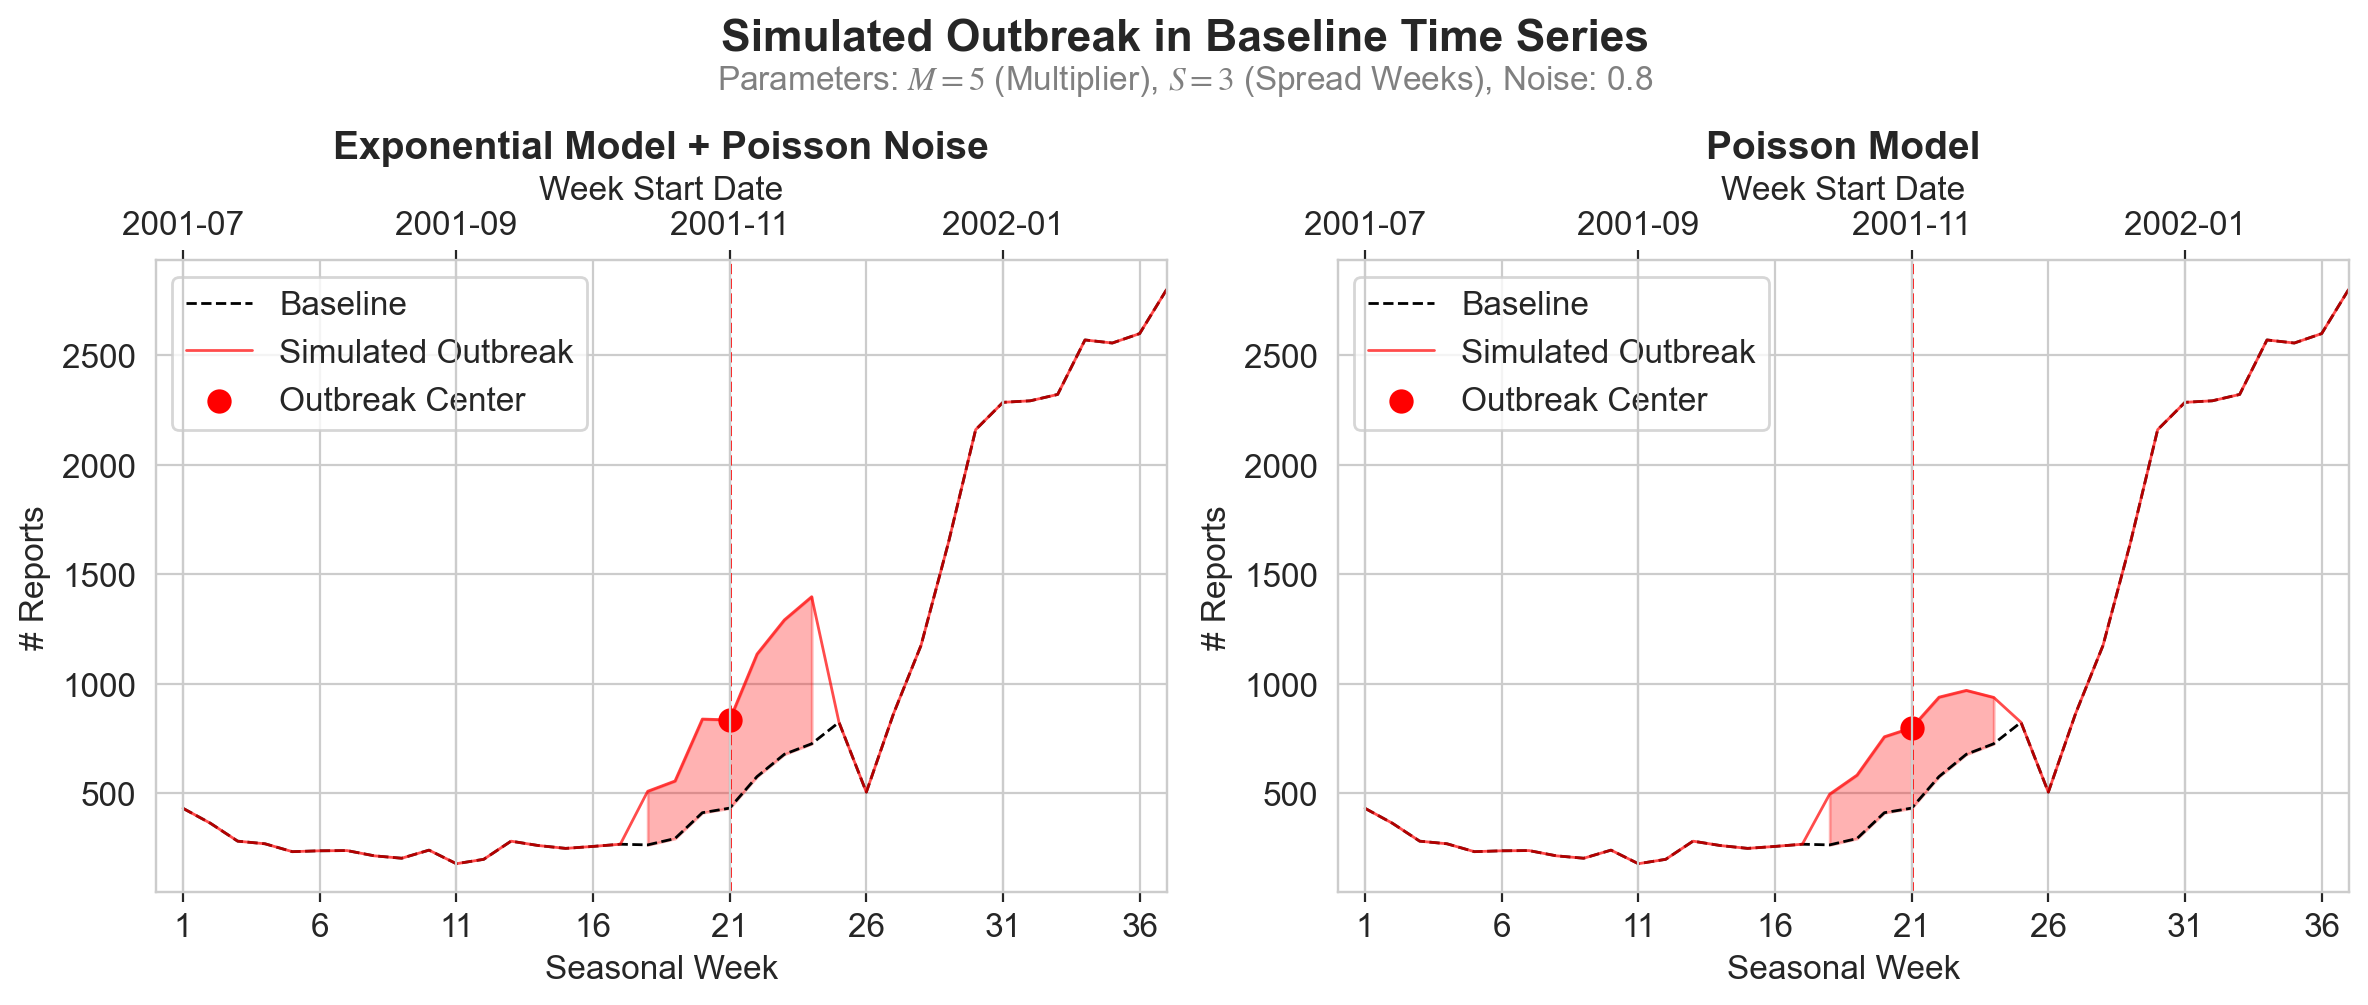

In [591]:
# Plot the simulated outbreak
interval = np.arange(0, 60)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, data, title in zip(
    axes,
    [baseline_with_outbreak_ex, baseline_with_outbreak_po],
    ["Exponential Model + Poisson Noise", "Poisson Model"],
):
    ax.plot(
        baseline[interval], label="Baseline", color="black", linestyle="--", linewidth=1
    )
    ax.plot(
        data[interval], label="Simulated Outbreak", color="red", linewidth=1, alpha=0.7
    )
    ax.scatter(center_idx, data[center_idx], color="red", label="Outbreak Center", s=60)

    # Highlight outbreak center with horizontal and vertical lines
    ax.axvline(center_idx, color="red", linestyle="--", linewidth=1)

    outbreak_weeks = np.arange(
        center_idx - config["simulation"]["spread_weeks"],
        center_idx + config["simulation"]["spread_weeks"] + 1,
    )
    # filter for interval
    outbreak_weeks = outbreak_weeks[
        (outbreak_weeks >= 0) & (outbreak_weeks < interval[-1])
    ]
    ax.fill_between(
        outbreak_weeks,
        baseline[outbreak_weeks],
        data[outbreak_weeks],
        color="red",
        alpha=0.3,
    )

    ax.set_xlabel("Seasonal Week")
    period = 5
    ax.set_xticks(seasonal_decomposition.index[::period])
    ax.set_xticklabels(seasonal_decomposition.seasonWeek[::period])
    ax.xaxis.set_ticks_position("bottom")
    ax.set_xlim(-1, 36)
    ax.set_ylabel("# Reports")

    secondary_axis = ax.twiny()
    secondary_axis.set_xlabel("Week Start Date")
    secondary_axis.set_xticks(seasonal_decomposition.index[:: period * 2])
    secondary_axis.set_xticklabels(
        seasonal_decomposition.week_start_date.dt.strftime("%Y-%m")[:: period * 2]
    )
    secondary_axis.set_xlim(-1, 36)

    ax.set_title(f"{title}")
    ax.legend(loc="upper left")

# Adjust main title and parameters title alignment
plt.suptitle(
    "Simulated Outbreak in Baseline Time Series", fontweight="bold", fontsize=16, y=1.0
)
plt.figtext(
    0.5,
    0.93,  # Place the parameter text centrally below the suptitle
    rf"Parameters: $M={config['simulation']['multiplier']}$ (Multiplier), $S={config['simulation']['spread_weeks']}$ (Spread Weeks), Noise: {config['simulation']['noise']}",
    ha="center",
    fontsize=12,
    color="gray",
)

plt.tight_layout()
plt.show()

Simulate outbreaks distributed across peak, mid, and low intervals. Added to that also taking into the account the group in which the interval falls. Such as year or total, so that the outbreaks are simulated in different periods and for eyery period/group equal number of outbreaks are simulated in peak, mid and low intervals.

In [592]:
def simulate_outbreaks(
    data,
    baseline,
    time_idx,
    period=None,
    num_outbreaks=3,
    multiplier=10,
    spread_weeks=4,
    method="exponential",
    noise=False,
):
    """
    Simulate outbreaks distributed across peak, mid, and low intervals.

    :param data: DataFrame
        Time series with seasonal decomposition of reported cases.
    :param col_baseline: str
        Column name with the baseline incidence.
    :param col_time: str
        Column name with the time index.
    :param num_outbreaks: int
        Number of outbreaks to simulate.
    :param period: str
        Period to simulate the outbreaks. Column name of the period or None.
    :param multiplier: int
        Intensity of the outbreak.
    :param spread_weeks: int
        Spread of the outbreak in weeks.
    :param method: str
        Method to model the outbreak's spread. Either "poisson" or "exponential".
    :param noise: bool
        Add Poisson noise to the simulated outbreak.
    :return: DataFrame
        Time series with simulated outbreaks.
    """
    df = data.copy()

    # Find peaks, mids and lows
    order = (
        spread_weeks * 2 + 1
    )  # Ensure outbreaks are spaced by at least as many weeks as a outbreak lasts -> no overlap between outbreaks
    peaks = argrelextrema(data["seasonal"].values, np.greater, order=order)[0]
    lows = argrelextrema(data["seasonal"].values, np.less, order=order)[0]
    mids = np.sort(np.concatenate((peaks, lows)))
    mids = np.diff(mids) // 2 + mids[:-1]
    # Add to DataFrame
    df["peak"] = df.index.isin(peaks)
    df["low"] = df.index.isin(lows)
    df["mid"] = df.index.isin(mids)

    # Get attributes
    baseline = df[baseline].values
    time_idx = df[time_idx].values

    # Select num_outbreaks random weeks, at least one in each interval
    least = num_outbreaks // 3
    num_peak = least
    num_low = least
    num_mid = least + num_outbreaks % 3

    # Define conditions and corresponding sample sizes
    conditions = [("peak", num_peak), ("low", num_low), ("mid", num_mid)]

    # Group by period if specified, else treat the entire DataFrame as one group
    groups = df.groupby(period) if period else [(None, df)]

    selected_centers_idx = []
    for _, group in groups:
        for condition, num_samples in conditions:
            # Check if enough rows exist to sample
            available_rows = len(group[group[condition]])
            if available_rows < num_samples:
                raise ValueError(
                    f"Not enough rows to sample {num_samples} for condition: {condition} (available: {available_rows})"
                )
            # Sample indices
            sampled_centers_idx = np.random.choice(
                group[group[condition]].index, num_samples, replace=False
            )
            selected_centers_idx.extend(sampled_centers_idx)

    # Concatenate all sampled indices into a single NumPy array
    print("Selected Outbreak Centers (idx):", np.array(selected_centers_idx))

    # Simulate outbreaks
    # Initialize
    combined = baseline.copy()
    outbreak_indicator = np.array([False] * len(baseline))
    for idx in selected_centers_idx:
        outbreak_sim, is_outbreak = simulate_outbreak(
            idx, combined, multiplier, spread_weeks, time_idx, method, noise
        )
        # Update combined
        combined = outbreak_sim
        # Update outbreak indicator
        outbreak_indicator = outbreak_indicator | is_outbreak

    df["simulated"] = combined
    df["is_outbreak"] = outbreak_indicator

    return df

In [593]:
%%time
df_simulated = simulate_outbreaks(
    data=seasonal_decomposition,
    baseline="observed",
    time_idx="week_start_date",
    period="seasonYear",
    num_outbreaks=config["simulation"]["n_outbreaks"],
    multiplier=config["simulation"]["multiplier"],
    spread_weeks=config["simulation"]["spread_weeks"],
    method=config["simulation"]["method"],
    noise=config["simulation"]["noise"],
)

Selected Outbreak Centers (idx): [  35    5   20   87   57   72  139  109  150  191  161  176  243  213
  228  295  265  306  347  317  358  399  369  384  451  421  436  503
  473  514  555  525  566  607  577  592  659  629  644  711  681  722
  763  733  748  815  785  826  867  837  878  919  889  930  971  941
  956 1023  993 1034 1075 1045 1086 1127 1097 1112 1179 1149 1164]
Outbreak Weeks: [32 33 34 35 36 37 38]
Outbreak Weeks: [2 3 4 5 6 7 8]
Outbreak Weeks: [17 18 19 20 21 22 23]
Outbreak Weeks: [84 85 86 87 88 89 90]
Outbreak Weeks: [54 55 56 57 58 59 60]
Outbreak Weeks: [69 70 71 72 73 74 75]
Outbreak Weeks: [136 137 138 139 140 141 142]
Outbreak Weeks: [106 107 108 109 110 111 112]
Outbreak Weeks: [147 148 149 150 151 152 153]
Outbreak Weeks: [188 189 190 191 192 193 194]
Outbreak Weeks: [158 159 160 161 162 163 164]
Outbreak Weeks: [173 174 175 176 177 178 179]
Outbreak Weeks: [240 241 242 243 244 245 246]
Outbreak Weeks: [210 211 212 213 214 215 216]
Outbreak Weeks: [225 

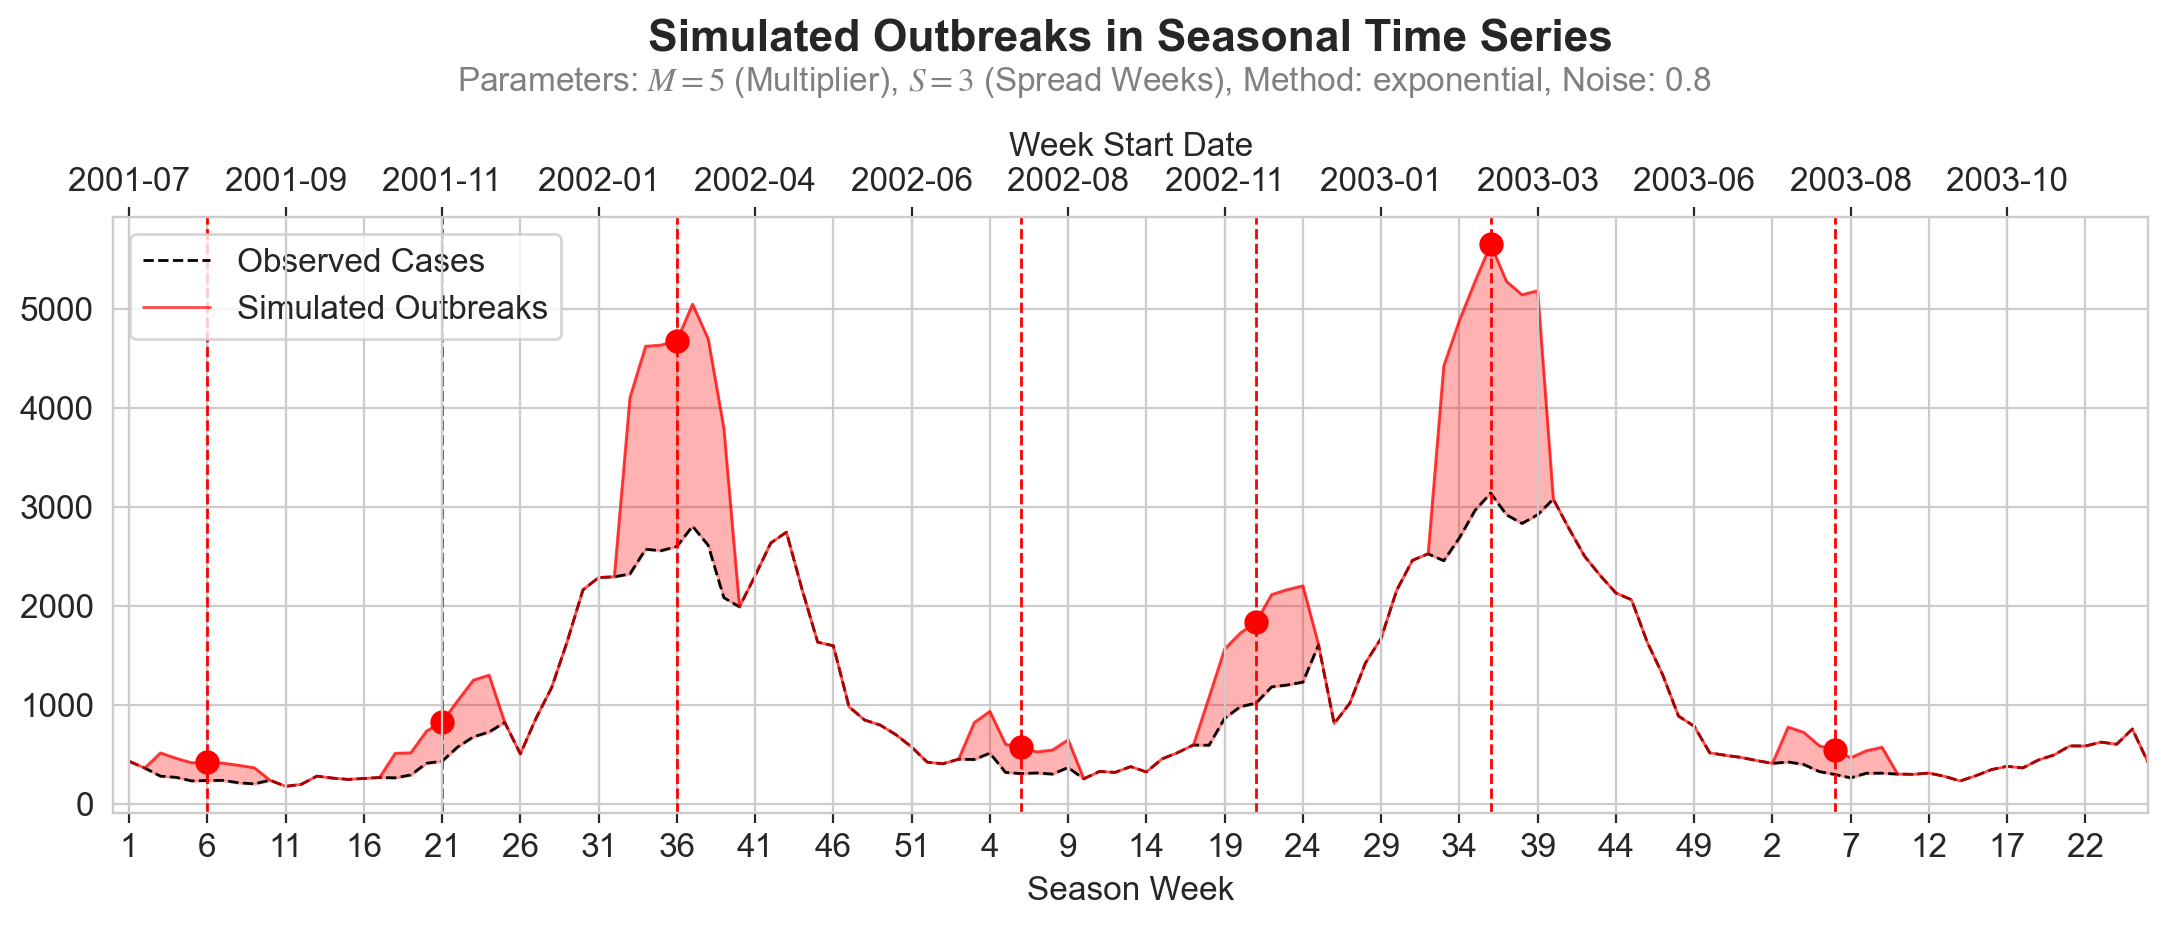

In [594]:
intervall = np.arange(0, 2.5 * 52)
# Plot the simulated outbreaks
fig, ax = plt.subplots(figsize=(11, 5))

# Plot observed and simulated cases
plt.plot(
    df_simulated["observed"].iloc[intervall],
    label="Observed Cases",
    color="black",
    linestyle="--",
    linewidth=1,
)
plt.plot(
    df_simulated["simulated"].iloc[intervall],
    label="Simulated Outbreaks",
    color="red",
    linewidth=1,
    alpha=0.7,
)

# Highlight outbreak weeks with shading and scatter points for the center
center_idx = df_simulated[
    df_simulated["is_outbreak"]
    & (df_simulated["peak"] | df_simulated["mid"] | df_simulated["low"])
].index
center_idx = center_idx[
    (center_idx >= intervall[0]) & (center_idx < intervall[-1])
]  # filter for intervall
for c in center_idx:
    ax.axvline(c, color="red", linestyle="--", linewidth=1)
    outbreak_weeks = np.arange(c - 4, c + 5)
    outbreak_weeks = outbreak_weeks[
        (outbreak_weeks >= 0) & (outbreak_weeks < len(df_simulated))
    ]
    ax.fill_between(
        outbreak_weeks,
        df_simulated["observed"][outbreak_weeks],
        df_simulated["simulated"][outbreak_weeks],
        color="red",
        alpha=0.3,
    )
    ax.scatter(c, df_simulated["simulated"][c], color="red", s=60)

# Set x-axis: Periodic ticks and custom labels
ax.set_xlabel("Season Week")
period = 5
ax.set_xticks(df_simulated.index[::period])
ax.set_xticklabels(df_simulated.seasonWeek[::period])
ax.xaxis.set_ticks_position("bottom")
ax.set_xlim(-1, intervall[-1])

# Add secondary x-axis with week start date
secondary_axis = ax.twiny()
secondary_axis.set_xlabel("Week Start Date")
secondary_axis.set_xticks(df_simulated.index[:: period * 2])
secondary_axis.set_xticklabels(
    df_simulated.week_start_date.dt.strftime("%Y-%m")[:: period * 2]
)
secondary_axis.set_xlim(-1, intervall[-1])

# Add a title and grid for better visibility
plt.title(
    "Simulated Outbreaks in Seasonal Time Series",
    fontweight="bold",
    fontsize=16,
    y=1.25,
)
plt.figtext(
    0.5,
    0.85,  # Place the parameter text centrally below the suptitle
    rf"Parameters: $M={config['simulation']['multiplier']}$ (Multiplier), $S={config['simulation']['spread_weeks']}$ (Spread Weeks), Method: {config['simulation']['method']}, Noise: {config['simulation']['noise']}",
    ha="center",
    fontsize=12,
    color="gray",
)

ax.legend(loc="upper left")

plt.tight_layout()
plt.show()

# Simulate reporting delays
The aim is to simulate reporting delays in the time series of reported cases. The delays are simulated using e.g. discretized log-normal, gamma distributions.


In [595]:
df_simulated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1196 entries, 0 to 1195
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   seasonYear       1196 non-null   object        
 1   seasonWeek       1196 non-null   int64         
 2   calendarYear     1196 non-null   int64         
 3   calendarWeek     1196 non-null   int64         
 4   week_start_date  1196 non-null   datetime64[ns]
 5   observed         1196 non-null   float64       
 6   trend            1196 non-null   float64       
 7   seasonal         1196 non-null   float64       
 8   resid            1196 non-null   float64       
 9   peak             1196 non-null   bool          
 10  low              1196 non-null   bool          
 11  mid              1196 non-null   bool          
 12  simulated        1196 non-null   float64       
 13  is_outbreak      1196 non-null   bool          
dtypes: bool(4), datetime64[ns](1), float64(5

In [596]:
import numpy as np
import pandas as pd


def generate_delays(n, shape=2, scale=2):
    """
    Generate delays using a Gamma distribution.

    :param n: int
        Number of time steps to simulate delays for.
    :param shape: float
        Shape parameter for the Gamma distribution.
    :param scale: float
        Scale parameter for the Gamma distribution.
    :return: array
        Simulated delays for each time step.
    """
    delays = np.random.gamma(shape, scale, size=n).astype(int)
    return delays


def apply_reporting_delays(data, delays, col_to_delay, max_delay=7):
    """
    Apply generated reporting delays to given data.

    :param data: DataFrame
        Time series data to apply delays to.
    :param delays: array
        Generated reporting delays to be applied to the data.
    :param col_to_delay: str
        Column name in the data to apply the delays to.
    :param max_delay: int
        Maximum delay value.
    :return: DataFrame
        Time series data with reporting delays applied
    """
    df_delayed = data.copy()

    # Create columns for each delay (simulated_d0, simulated_d1, ..., simulated_d7)
    for d in range(max_delay + 1):
        df_delayed[f"{col_to_delay}_d{d}"] = 0

    # Apply the delays for each time step
    for idx, delay in enumerate(delays):
        if idx + delay < len(df_delayed):  # Ensure we do not go out of bounds
            df_delayed[f"{col_to_delay}_d{delay}"].iloc[idx + delay] += df_delayed[
                col_to_delay
            ].iloc[idx]

    return df_delayed


# Generate delays
delays = generate_delays(len(df_simulated), shape=2, scale=2)

# Apply reporting delays
data_with_delays = apply_reporting_delays(
    df_simulated, delays, col_to_delay="observed", max_delay=7
)

data_with_delays.head(10)

C:\Users\merti\AppData\Local\Temp\ipykernel_2788\3022965196.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_delayed[f"{col_to_delay}_d{delay}"].iloc[idx + delay] += df_delayed[col_to_delay].iloc[idx]
C:\Users\merti\AppData\Local\Temp

KeyError: 'observed_d12'

In [ ]:
# Test functionality
delays = generate_delays(len(df_simulated), shape=2, scale=2)
df_with_delays = apply_reporting_delays(
    df_simulated, delays, col_to_delay="simulated", max_delay=7
)

In [ ]:
df_with_delays.head(10)